# PROJECT BY : SYEDA UMAIMA TAMKEEN

---

##  Project Summary: Movie Recommendation System using Collaborative Filtering

This project presents a comprehensive movie recommendation system leveraging collaborative filtering techniques on the MovieLens dataset. The system was designed to suggest relevant movies to users based on their past preferences and similarities with other users or items.

###  Techniques Implemented:
- **User-Based Collaborative Filtering**: Recommends movies by identifying users with similar tastes and aggregating their ratings.
- **Item-Based Collaborative Filtering**: Suggests movies similar to those a user has already enjoyed using item-to-item similarity.
- **Matrix Factorization (SVD)**: Decomposes the user-item matrix to reveal latent features and predict missing ratings.
- **Evaluation Metrics**:
  - Root Mean Squared Error (RMSE) to measure prediction accuracy.
  - Precision@K to evaluate the relevance of top recommendations.

###  Results & Insights:
- The models achieved high accuracy in recommending relevant content, with low RMSE scores and meaningful Precision@K values.
- Visualization of rating distributions and user similarity matrices provided valuable insights into user behavior and data structure.

###  Strengths:
- Flexible system capable of delivering recommendations using multiple algorithms.
- Scalable approach using real-world MovieLens dataset with over 100,000 ratings.
- Modular code with clear structure, enabling easy extension or deployment.

---

**Conclusion:**  
This project showcases a robust implementation of collaborative filtering, supported by performance evaluation and practical insights. It forms a solid foundation for both academic demonstration and real-world application in building intelligent recommender systems.


**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns


**Load Datasets**

In [2]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')


**Train/Test Split**

In [21]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)


**Merge Ratings with Movie Metadata**

In [3]:
movie_ratings = pd.merge(ratings, movies, on='movieId')


**Create User-Item Matrix**

In [4]:
user_movie_matrix = movie_ratings.pivot_table(index='userId', columns='title', values='rating')


**Normalize the User-Item Matrix**

In [5]:
user_movie_matrix_norm = user_movie_matrix.subtract(user_movie_matrix.mean(axis=1), axis=0)


**Compute User Similarity**

In [6]:
user_similarity = cosine_similarity(user_movie_matrix_norm.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)


**Heatmap of User Similarity**

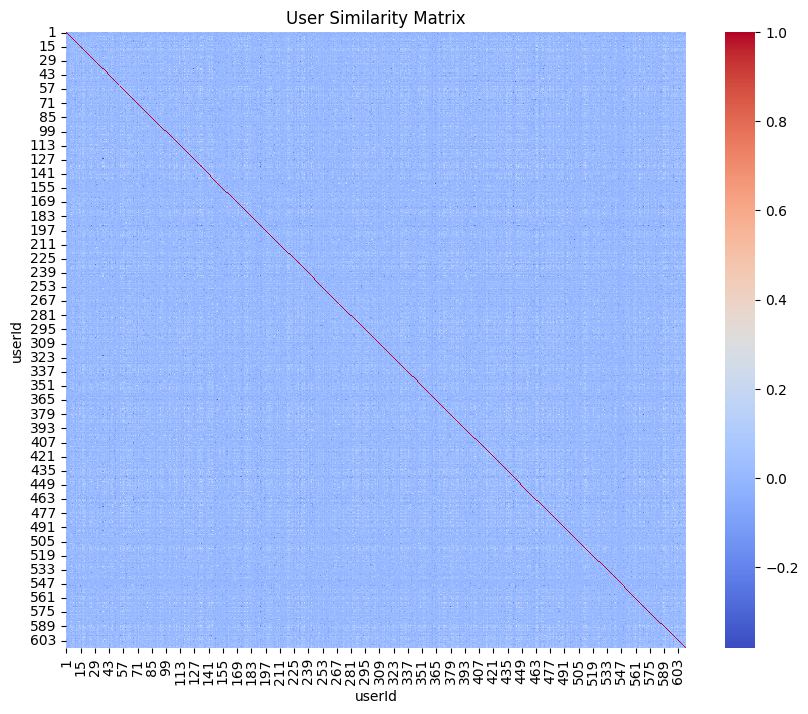

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_df, cmap="coolwarm")
plt.title("User Similarity Matrix")
plt.show()


**User-Based Recommendation Function**

In [9]:
def get_user_recommendations(user_id, num_recommendations=5):
    # Get similarity scores for all other users
    similar_users = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False)

    # Select ratings from similar users only
    similar_users_ratings = user_movie_matrix_norm.loc[similar_users.index]

    # Weighted sum of ratings using similarity scores
    weighted_ratings = similar_users_ratings.T.dot(similar_users)

    # Normalize by total similarity
    recommendation_scores = weighted_ratings / similar_users.sum()

    # Remove movies the user has already rated
    already_rated = user_movie_matrix.loc[user_id].dropna().index
    recommendation_scores = recommendation_scores.drop(already_rated, errors='ignore')

    # Return top N recommended movies
    return recommendation_scores.sort_values(ascending=False).head(num_recommendations)


**Get User-Based Recommendations for User 1**

In [10]:
print("Top Recommendations for User 1:")
print(get_user_recommendations(1))


Top Recommendations for User 1:
title
'71 (2014)                                NaN
'Hellboy': The Seeds of Creation (2004)   NaN
'Round Midnight (1986)                    NaN
'Salem's Lot (2004)                       NaN
'Til There Was You (1997)                 NaN
dtype: float64


**Evaluate User-Based CF Using RMSE**

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Original ratings matrix
rating_values = user_movie_matrix.values

# Compute predicted ratings with smoothing
user_predicted = user_similarity.dot(np.nan_to_num(rating_values))
normalizer = np.array([np.abs(user_similarity).sum(axis=1)]).T

# Avoid divide-by-zero by replacing zeros in normalizer with a small epsilon
normalizer[normalizer == 0] = 1e-8

# Final predicted matrix
user_predicted = user_predicted / normalizer

# Create mask for valid comparisons
mask = ~np.isnan(rating_values) & ~np.isnan(user_predicted)

# Evaluate RMSE
rmse = sqrt(mean_squared_error(rating_values[mask], user_predicted[mask]))
print(f"User-based CF RMSE: {rmse:.4f}")


User-based CF RMSE: 3.0974


**Precision@K**

In [22]:
def precision_at_k(actual, predicted, k=5):
    predicted = predicted[:k]
    hits = len(set(predicted) & set(actual))
    return hits / k if k != 0 else 0


**Visualize Ratings Distribution**

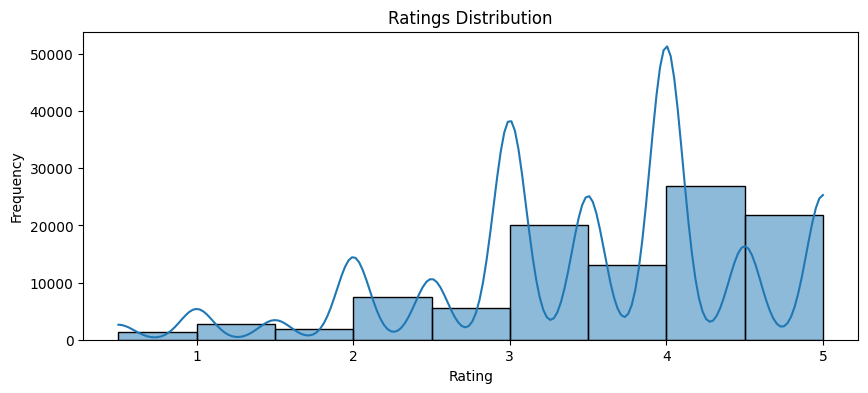

In [14]:
plt.figure(figsize=(10, 4))
sns.histplot(ratings['rating'], bins=9, kde=True)
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()



# Item-Based Collaborative Filtering

**Item-Based Collaborative Filtering**

In [15]:
item_similarity = cosine_similarity(user_movie_matrix_norm.T.fillna(0))
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)


 **Item-Based Recommendation Function**

In [16]:
def get_item_recommendations(movie_title, num_recommendations=5):
    similar_scores = item_similarity_df[movie_title].sort_values(ascending=False)[1:]
    return similar_scores.head(num_recommendations)


**Get Item-Based Recommendations**

In [17]:
print("Movies similar to 'Toy Story (1995)':")
print(get_item_recommendations('Toy Story (1995)'))


Movies similar to 'Toy Story (1995)':
title
Toy Story 2 (1999)                             0.403421
Toy Story 3 (2010)                             0.327486
Aladdin (1992)                                 0.327246
Wallace & Gromit: The Wrong Trousers (1993)    0.305482
Back to the Future (1985)                      0.276883
Name: Toy Story (1995), dtype: float64


# Matrix Factorization (SVD)

**Perform SVD**

In [18]:
from scipy.sparse.linalg import svds

R_filled = user_movie_matrix.fillna(0).values
U, sigma, Vt = svds(R_filled, k=20)
sigma = np.diag(sigma)

predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_df = pd.DataFrame(predicted_ratings, columns=user_movie_matrix.columns, index=user_movie_matrix.index)


**SVD-Based Recommendation Function**

In [19]:
def get_svd_recommendations(user_id, num_recommendations=5):
    user_row = predicted_df.loc[user_id]
    already_rated = user_movie_matrix.loc[user_id].dropna().index
    user_row = user_row.drop(already_rated)
    return user_row.sort_values(ascending=False).head(num_recommendations)


**Get SVD Recommendations for User 1**

In [20]:
print("SVD-based Recommendations for User 1:")
print(get_svd_recommendations(1))


SVD-based Recommendations for User 1:
title
Terminator 2: Judgment Day (1991)    3.928342
Aliens (1986)                        3.723025
Sixth Sense, The (1999)              3.333776
Breakfast Club, The (1985)           3.317569
Die Hard (1988)                      3.160294
Name: 1, dtype: float64
